### Packages

In [1]:
import numpy as np
import pandas as pd
from numba import jit
import random
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
aspect_ratio = 1.5
plt.style.use('ggplot')
from pprint import pprint
from IPython.display import display
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

<Figure size 800x800 with 0 Axes>

### Game Setup

In [2]:
import numpy as np
from numba import jit

def game_setup(max_rounds = 6, max_periods = 6, max_tokens = 6, max_K = 6, minprice = 1, maxprice = 2000, nsteps = 25):
    
    # generate num rounds, num periods and num tokens
    nrounds = np.random.randint(1,max_rounds)
    nperiods = np.random.randint(1,max_periods)
    ntokens = np.random.randint(1,max_tokens)
    
    # generate R1, R2, R3, R4 which will define token distribution
    gametype_1 = np.random.randint(1,max_K)
    gametype_2 = np.random.randint(1,max_K)
    gametype_3 = np.random.randint(1,max_K)
    gametype_4 = np.random.randint(1,max_K)
    R1 = 3 ** gametype_1 - 1
    R2 = 3 ** gametype_2 - 1
    R3 = 3 ** gametype_3 - 1
    R4 = 3 ** gametype_4 - 1
    
    return nrounds, nperiods, ntokens, R1, R2, R3, R4, minprice, maxprice, nsteps

def round_setup(ntokens, nbuyers, nsellers, R1, R2, R3, R4):
    
    # draw a set of token value from give token distribution
    A = np.random.uniform(0,R1)
    B = np.random.uniform(0,R2)
    C = np.random.uniform(0,R3,(nbuyers + nsellers,1))
    D = np.random.uniform(0,R4,(nbuyers + nsellers,ntokens))
    token_values = A + B + C + D
    
    return np.round(token_values,1)

In [3]:
round_setup(1,1,1,20,20,20,20)

array([[53.4],
       [52.4]])

### Compute Equilibrium

In [197]:
@jit
def token_value_breakup(token_values,nbuyers,nsellers):
    
    # break tokens between buyers and sellers
    buyer_token_values = token_values[0:nbuyers,:]
    seller_token_values = token_values[nbuyers:nbuyers+nsellers,:]
    
    # obtain minimum and maximum prices
    max_eqbm_price = np.max(buyer_token_values)
    min_eqbm_price = np.min(seller_token_values)
    
    return buyer_token_values, seller_token_values, max_eqbm_price, min_eqbm_price

@jit
def compute_demand_curve(buyer_token_values,nbuyers,ntokens,min_eqbm_price,max_eqbm_price,granularity=1000):
    # create a grid of price based on minimum and maximum price
    P_grid = np.linspace(min_eqbm_price,max_eqbm_price,granularity)
    
    # find number of units that would be demanded as price rises
    demand_schedule = np.zeros((granularity),dtype = 'int')
    for i, p in enumerate(P_grid):
        demand = np.sum(p<buyer_token_values) # how many tokens are buyers ready to buy at this price
        demand_schedule[i] = demand
        
    return demand_schedule, P_grid

@jit
def compute_supply_curve(seller_token_values,nsellers,ntokens,min_eqbm_price,max_eqbm_price,granularity=1000):
    # create a grid of price based on minimum and maximum price
    P_grid = np.linspace(min_eqbm_price,max_eqbm_price,granularity)

    # find number of units that would be supplied as price rises
    supply_schedule = np.zeros((granularity), dtype = 'int')
    for i, p in enumerate(P_grid):
        supply = np.sum(p>seller_token_values) # how much sellers are ready to sell at this price
        supply_schedule[i] = supply
        
    return supply_schedule, P_grid

@jit
def find_equilibrium(demand_schedule,supply_schedule,P_grid):
    
    # create price equilibrium placeholders
    p_eqbm = []
    q_eqbm = None
    
    # find prices at which demand and supply clears
    for i, p in enumerate(P_grid):
        if demand_schedule[i] == supply_schedule[i]: # when sellers are ready to sell
            p_eqbm.append(p)
            q_eqbm = demand_schedule[i]
            
    return p_eqbm, q_eqbm

def compute_demand_supply(token_values, ntokens, nbuyers, nsellers):
    # split buyer and seller tokens
    buyer_token_values, seller_token_values, max_eqbm_price, min_eqbm_price = token_value_breakup(token_values,nbuyers,nsellers)
    
    # find demand curve
    demand_schedule, P_grid = compute_demand_curve(buyer_token_values,nbuyers,ntokens,min_eqbm_price,max_eqbm_price)
    
    # find supply curve
    supply_schedule, P_grid = compute_supply_curve(seller_token_values,nsellers,ntokens,min_eqbm_price,max_eqbm_price)
    
    # compute equilibrium
    p_eqbm, q_eqbm = find_equilibrium(demand_schedule,supply_schedule,P_grid)
    return p_eqbm, q_eqbm

def plot_period_results(period_bids, period_asks, period_prices, period_sales, token_values, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4):
    
    # compute equilibrium
    buyer_token_values, seller_token_values, max_eqbm_price, min_eqbm_price = token_value_breakup(token_values,nbuyers,nsellers)
    demand_schedule, P_grid = compute_demand_curve(buyer_token_values,nbuyers,ntokens,min_eqbm_price,max_eqbm_price)
    supply_schedule, P_grid = compute_supply_curve(seller_token_values,nsellers,ntokens,min_eqbm_price,max_eqbm_price)
    p_eqbm, q_eqbm = find_equilibrium(demand_schedule,supply_schedule,P_grid)
    
    # plot demand and supply schedules
    plt.plot(demand_schedule, P_grid, label = 'Demand Curve')
    plt.plot(supply_schedule, P_grid, label = 'Supply Curve')
    count = 0
    prices = []
    
    # plot the actual bids and asks, including actual prices
    for i in range(nsteps):
        bids = period_bids[i]
        asks = period_asks[i]
        price = period_prices[i]
        sales = period_sales[i]
        if price != np.nan:
            plt.scatter([sales]*len(bids), bids, s = 10, marker = 'x', c = 'red')
            plt.scatter([sales]*len(asks), asks, s = 10, marker = 'o', c = 'blue')
            #plt.scatter(sales, price, s = 20, marker = '^', c = 'green')
        else:
            pass
        
    # plot average and equilibrium prices    
    plt.axhline(y=np.nanmean(period_prices), color='green', linestyle='--', label='Mean Real Prices')
    plt.axhline(y=np.nanmean(p_eqbm), color='black', linestyle='--', label='Mean Eqbm Prices')
    plt.legend()
    plt.show()
    
    # print information
    print('Eqbm quantity:', q_eqbm)
    try:
        print('Eqbm prices:', p_eqbm[0], 'to', p_eqbm[-1])
    except:
        print('No Eqbm price')
    try:
        print('Avg Prices:', np.nanmean(period_prices))
        print('Actual quantity', np.nanmax(period_sales))
    except: 
        print('No sales')


    plt.plot(period_bids, c = 'r', linestyle='--')
    plt.plot(period_asks,  c = 'b', linestyle='--')
    plt.scatter(range(25), period_prices, c = 'g')
    plt.title('Bids, Asks, Prices over time')
    plt.show()


### Trading Strategies

In [201]:
class Trader:
    # initialize agent at beginning of game with public information
    def __init__(self, public_information, name, buyer=True):
        self.name, self.buyer = name, buyer
        self.step_profit, self.period_profit, self.round_profit, self.game_profit, self.bids_on_this_token = 0, 0, 0, 0, 0
        self.nrounds, self.nperiods, self.ntokens, self.nbuyers, self.nsellers, self.R1, self.R2, self.R3, self.R4, self.minprice, self.maxprice, self.nsteps = public_information 
        
    # at start of round, add the private information
    def reset_round(self, token_values):
        self.step_profit, self.period_profit, self.round_profit = 0, 0, 0
        self.token_values = list(np.round(np.sort(token_values, kind='quicksort')[::-1],1))
        if self.buyer == True:
            self.num_tokens_held = 0
            self.tokens_held = []
            self.bids_on_this_token = 0
        else:
            self.num_tokens_held = len(self.token_values)
            self.tokens_held = self.token_values

    # at end of period, reset data
    def reset_period(self, token_values):
        self.step_profit, self.period_profit, self.round_profit = 0, 0, 0
        self.token_values = list(np.round(np.sort(token_values, kind='quicksort')[::-1],1))
        if self.buyer == True:
            self.num_tokens_held = 0
            self.tokens_held = []
            self.period_profit = 0
            self.bids_on_this_token = 0
        else:
            self.num_tokens_held = len(self.token_values)
            self.tokens_held = self.token_values
            self.period_profit = 0
    
    # make the transaction
    def transact(self, price):
        if self.buyer == True:
            self.num_tokens_held += 1
            self.tokens_held.append(self.value)
            self.step_profit = self.value-price
            self.bids_on_this_token = 0
        else:
            self.num_tokens_held = self.num_tokens_held -1
            self.tokens_held.remove(self.value)
            self.step_profit = price-self.value

    def describe(self):
        print(f"\n")
        print(f"Name: {self.name}")
        print(f"Buyer: {self.buyer}")
        print(f"Tokens Held: {self.tokens_held}")
        print(f"Token Values: {self.token_values}")
        print(f"Period Profit: {self.period_profit}")
        print(f"Round Profit: {self.round_profit}")
        print(f"Game Profit: {self.game_profit}")

### Trading Types
- Random
- Honest
- Sniper
- Creeper
- Forecaster
- Q-learner

#### Random

In [202]:
class Random(Trader):
    def __init__(self, public_information, name, buyer=True):
        super().__init__(public_information, name, buyer)

    def bid(self, db):
        if self.num_tokens_held == len(self.token_values):
            return np.nan
        n = self.num_tokens_held + 1 # index of token
        self.value = np.partition(self.token_values, -n)[-n] # get nth max
        self.bid_amount = np.round(np.random.uniform(0.8*self.value, self.value, 1).item(),1)
        return self.bid_amount
    
    def ask(self, db):
        if self.num_tokens_held == 0:
            return np.nan
        n = self.num_tokens_held
        self.value = np.partition(self.token_values, -n)[-n]
        self.ask_amount = np.round(np.random.uniform(self.value, 1.2*self.value, 1).item(),1)
        return self.ask_amount
    
    def buy(self, current_bid, current_ask):
        if current_ask <= current_bid:
            return True
        else:
            return False
        
    def sell(self, current_bid, current_ask):
        if current_ask <= current_bid:
            return True
        else:
            return False

#### Honest

In [203]:
class Honest(Trader):
    def __init__(self, public_information, name, buyer=True):
        super().__init__(public_information, name, buyer)

    def bid(self, db):
        if self.num_tokens_held == len(self.token_values):
            return np.nan
        n = self.num_tokens_held + 1 # index of token
        self.value = np.partition(self.token_values, -n)[-n] # get nth max
        self.bid_amount = self.value
        return self.bid_amount
    
    def ask(self, db):
        if self.num_tokens_held == 0:
            return np.nan
        n = self.num_tokens_held
        self.value = np.partition(self.token_values, -n)[-n]
        self.ask_amount = self.value
        return self.ask_amount
    
    def buy(self, current_bid, current_ask):
        if current_ask <= current_bid:
            return True
        else:
            return False
        
    def sell(self, current_bid, current_ask):
        if current_ask <= current_bid:
            return True
        else:
            return False

#### Sniper

In [204]:
class Sniper(Trader):
    def __init__(self, public_information, name, buyer=True):
        super().__init__(public_information, name, buyer)

    def bid(self, db):
        if (self.num_tokens_held == len(self.token_values)):
            return np.nan
        n = self.num_tokens_held + 1 # index of token
        self.value = np.partition(self.token_values, -n)[-n] # get nth max
        self.bid_amount = np.nan
        try: 
            data = db.step_data.iloc[-1]
            if (data.step > 0):
                if (data.current_bid > 0.9 * data.current_ask):
                    self.bid_amount = data.current_ask
        except: 
            pass
        return self.bid_amount
    
    def ask(self, db):
        if self.num_tokens_held == 0:
            return np.nan
        n = self.num_tokens_held
        self.value = np.partition(self.token_values, -n)[-n]
        self.ask_amount = np.nan
        try: 
            data = db.step_data.iloc[-1]
            if (data.step > 0):
                if (data.current_bid > 0.9 * data.current_ask):
                    self.ask_amount = data.current_bid
        except: 
            pass
        return self.ask_amount
    
    def buy(self, current_bid, current_ask):
        if current_ask <= current_bid:
            return True
        else:
            return False
        
    def sell(self, current_bid, current_ask):
        if current_ask <= current_bid:
            return True
        else:
            return False

In [205]:
db.step_data.iloc[-1]

rnd                                 3
period                              3
step                               24
bids               [35.2, 42.8, 38.4]
asks                [44.6, 43.1, nan]
current_bid                      42.8
current_bid_idx                     1
current_ask                      43.1
current_ask_idx                     1
buy                                 0
sell                                0
price                             NaN
sale                                0
bprofit                           0.0
sprofit                           0.0
p_eqbm                      44.343844
q_eqbm                              6
Name: 399, dtype: object

#### Creeper

In [206]:
class Creeper(Trader):
    def __init__(self, public_information, name, buyer=True):
        super().__init__(public_information, name, buyer)

    def bid(self, db):
        if (self.num_tokens_held == len(self.token_values)):
            return np.nan
        n = self.num_tokens_held + 1 # index of token
        self.value = np.partition(self.token_values, -n)[-n] # get nth max
        if self.bids_on_this_token == 0:
            self.bid_amount = self.value*0.8
        else:
            data = db.step_data.iloc[-1]
            if data.sale == 0:
                self.bid_amount = np.min([self.value,self.bid_amount+0.2*(self.value - self.bid_amount)]) 
        self.bids_on_this_token += 1
        return np.round(self.bid_amount,1)
    
    def ask(self, db):
        if self.num_tokens_held == 0:
            return np.nan
        n = self.num_tokens_held
        self.value = np.partition(self.token_values, -n)[-n] # get nth max
        try: 
            data = db.step_data.iloc[-1]
            if (data.step > 0):
                if (data.current_ask_idx != int(self.name[-1])):
                    self.ask_amount += 0.2*(self.value - self.ask_amount) # decrease if didn't get current_ask
            else:
                self.ask_amount = self.value*1.2 # ask at start of the game
        except: 
            print('hap')
            self.ask_amount = self.value*1.2
        return np.round(self.ask_amount,1)
    
    def buy(self, current_bid, current_ask):
        if current_ask <= current_bid:
            return True
        else:
            return False
        
    def sell(self, current_bid, current_ask):
        if current_ask <= current_bid:
            return True
        else:
            return False

#### Generate Agents

In [207]:

def generate_agents(buyer_strategies, seller_strategies, public_information):
    
    # populate a set of buyers
    buyers = []
    for idx,i in enumerate(buyer_strategies):
        if i == 'Honest':
            buyers.append(Honest(public_information,'B'+str(idx),buyer=True))   
        if i == 'Random':
            buyers.append(Random(public_information,'B'+str(idx),buyer=True))   
        if i == 'Sniper':
            buyers.append(Sniper(public_information,'B'+str(idx),buyer=True))   
        if i == 'Creeper':
            buyers.append(Creeper(public_information,'B'+str(idx),buyer=True))   
                                        
    # populate a set of sellers
    sellers = []
    for idx,i in enumerate(seller_strategies):
        if i == 'Honest':
            sellers.append(Honest(public_information,'S'+str(idx),buyer=False))   
        if i == 'Random':
            sellers.append(Random(public_information,'S'+str(idx),buyer=False))   
        if i == 'Sniper':
            sellers.append(Sniper(public_information,'S'+str(idx),buyer=False))   
        if i == 'Creeper':
            sellers.append(Creeper(public_information,'S'+str(idx),buyer=False))   
                    
    return buyers, sellers

### Database

In [222]:
class Database:
    def __init__(self, game_metadata, buyers, sellers):
        self.game_metadata = game_metadata
        self.nrounds, self.nperiods, self.ntokens, self.nbuyers, self.nsellers, self.R1, self.R2, self.R3, self.R4, self.minprice, self.maxprice, self.nsteps = game_metadata       
        self.buyers = buyers
        self.sellers = sellers
        self.step_data = pd.DataFrame(columns=['rnd', 'period', 'step', 'bids','asks','current_bid','current_bid_idx','current_ask','current_ask_idx','buy','sell','price','sale', 'bprofit', 'sprofit', 'p_eqbm','q_eqbm'])
        self.round_data = pd.DataFrame(columns=['rnd', 'token_values', 'p_eqbm', 'q_eqbm'])
        
    def add_step(self, data):
        self.step_data.loc[len(self.step_data.index)] = data

    def add_round(self, data):        
        self.round_data.loc[len(self.round_data.index)] = data
        
    def get_period(self, rnd, period):
        temp = db.step_data[(db.step_data.rnd==rnd) & (db.step_data.period==period)]
        temp = temp[['step', 'bids', 'asks', 'current_bid', 'current_bid_idx', 'current_ask','current_ask_idx','price', 'bprofit', 'sprofit']]
        return temp

    def get_round(self, rnd):
        print(f"Rounds:{self.nrounds}, Periods{self.nperiods}, Tokens:{self.ntokens}, Buyers:{self.nbuyers}, Sellers{self.nsellers}, R1 to R4:{self.R1, self.R2, self.R3, self.R4}")
        temp = db.round_data[(db.round_data.rnd==rnd)]
        temp = temp[['token_values', 'p_eqbm', 'q_eqbm']]
        return temp

    def get_token_values(self, rnd):
        return db.round_data[(db.round_data.rnd==rnd)].token_values
    
    def graph_period(self, rnd, period):
        period_bids = list(db.get_period(rnd, period).bids)
        period_asks = list(db.get_period(rnd, period).asks)
        period_prices = list(db.get_period(rnd, period).price)
        period_sales = np.cumsum(np.where(db.get_period(rnd, period).price > 0,1,0))
        token_values = db.get_round(rnd).token_values.item()
        ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4 = db.ntokens, db.nbuyers, db.nsellers, db.nsteps, db.R1, db.R2, db.R3, db.R4
        plot_period_results(period_bids, period_asks, period_prices, period_sales, token_values, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4)


### TradingGame

In [223]:
def TradingGame(buyer_strategies, seller_strategies, verbose = 0):
    #nrounds, nperiods, ntokens, R1, R2, R3, R4, minprice, maxprice, nsteps = game_setup()
    nrounds, nperiods, ntokens, R1, R2, R3, R4, minprice, maxprice, nsteps = 4, 4, 4, 20, 20, 20, 20, 1, 100, 25
    nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
    game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, R1, R2, R3, R4, minprice, maxprice, nsteps]
    buyers, sellers = generate_agents(buyer_strategies, seller_strategies, game_metadata)
    db = Database(game_metadata, buyers, sellers)

    # Begin game
    for rnd in range(nrounds):

        # assign token values
        token_values = round_setup(ntokens, nbuyers, nsellers, R1, R2, R3, R4)
        for i in range(nbuyers):
            db.buyers[i].reset_round(token_values[i])
        for i in range(nsellers):
            db.sellers[i].reset_round(token_values[nbuyers+i])
            
        # store round data
        p_eqbm, q_eqbm = compute_demand_supply(token_values, ntokens, nbuyers,nsellers)
        db.add_round([rnd, token_values, p_eqbm, q_eqbm])
        try:
            p_eqbm = np.nanmean(p_eqbm)
        except:
            p_eqbm = np.nan
        
        for period in range(nperiods):
            
            # reset period
            for i in range(nbuyers):
                db.buyers[i].reset_period(token_values[i])
            for i in range(nsellers):
                db.sellers[i].reset_period(token_values[i])
            
            for step in range(nsteps):

                # bid/ask step
                bids = [buyer.bid(db) for buyer in db.buyers]
                asks = [seller.ask(db) for seller in db.sellers]

                if np.all(np.isnan(asks)) == False:
                    print(bids)
                    current_bid_idx = np.nanargmax(bids)
                    current_bid = np.nanmax(bids)
                else:
                    current_bid_idx = np.nan
                    current_bid = np.nan

                if np.all(np.isnan(asks)) == False:
                    current_ask_idx = np.nanargmin(asks)
                    current_ask = np.nanmin(asks)
                else:
                    current_ask_idx = np.nan
                    current_ask = np.nan

                # buy/sell step 
                sale = 0
                price = np.nan
                bprofit = np.nan
                sprofit = np.nan
                buy = 0
                sell = 0
                bprofit = 0
                sprofit = 0
                try:
                    if db.buyers[current_bid_idx].buy(current_bid,current_ask):
                        buy = 1
                    if db.sellers[current_ask_idx].sell(current_bid,current_ask):
                        sell = 1
                    if buy == 1 and sell == 1:
                        price = np.random.choice([current_bid,current_ask])
                        db.buyers[current_bid_idx].transact(price)
                        db.sellers[current_ask_idx].transact(price)
                        sale = 1
                        bprofit = db.buyers[current_bid_idx].step_profit
                        sprofit = db.sellers[current_ask_idx].step_profit
                except:
                    buy = np.nan
                    sell = np.nan
                    
                # store step data
                step_data = [rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit, p_eqbm, q_eqbm]
                db.add_step(step_data)
        
    return db

### Analysis

In [224]:
def individual_outcomes(df, buyers = True):
    a = df.groupby(['current_ask_idx']).mean()[['current_ask', 'price','sprofit']]
    b = df.groupby(['current_ask_idx']).sum()[['sell','sprofit']]
    seller_outcome = pd.concat([a,b], axis = 1)
    seller_outcome.columns = ['mean_asks', 'mean_price', 'mean_profit','total_sales','total_profit']
    a = df.groupby(['current_bid_idx']).mean()[['current_bid', 'price','bprofit']]
    b = df.groupby(['current_bid_idx']).sum()[['sell','bprofit']]
    buyer_outcome = pd.concat([a,b], axis = 1)
    buyer_outcome.columns = ['mean_bids', 'mean_price', 'mean_profit','total_sales','total_profit']
    if buyers == True:
        return buyer_outcome
    else:
        return seller_outcome
    

def market_outcomes(df):
    a = df.groupby(['rnd', 'period']).mean()[['price','p_eqbm','q_eqbm']]
    b = df.groupby(['rnd', 'period']).sum()[['sell']]
    market = pd.concat([a,b], axis = 1)
    market.columns = ['mean_market_price', 'p_eqbm', 'q_eqbm','total_sales']
    return market

### Simulations

In [225]:
buyer_strategies = ['Honest']
seller_strategies = ['Honest','Honest','Honest','Honest']
db = TradingGame(buyer_strategies, seller_strategies, verbose = 1)

[36.1]
[35.6]
[30.0]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[36.1]
[35.6]
[30.0]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[36.1]
[35.6]
[30.0]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[36.1]
[35.6]
[30.0]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[26.6]
[49.1]
[48.0]
[40.0]
[30.4]
[nan]


ValueError: All-NaN slice encountered

In [ ]:
rnd = 0
period = 0
db.get_token_values(rnd).item()

In [ ]:
df = db.step_data
individual_outcomes(df)

Rounds:4, Periods4, Tokens:4, Buyers:1, Sellers1, R1 to R4:(20, 20, 20, 20)


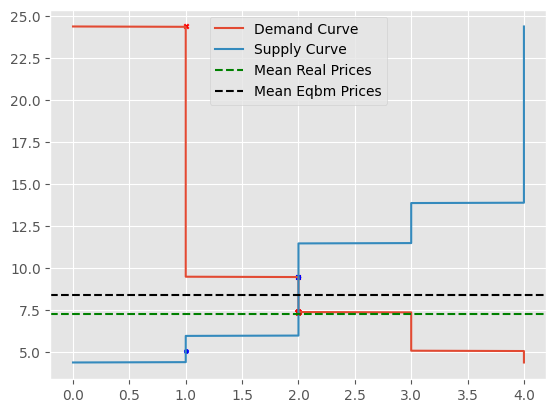

Eqbm quantity: 2
Eqbm prices: 7.403003003003003 to 9.485085085085085
Avg Prices: 7.3
Actual quantity 2


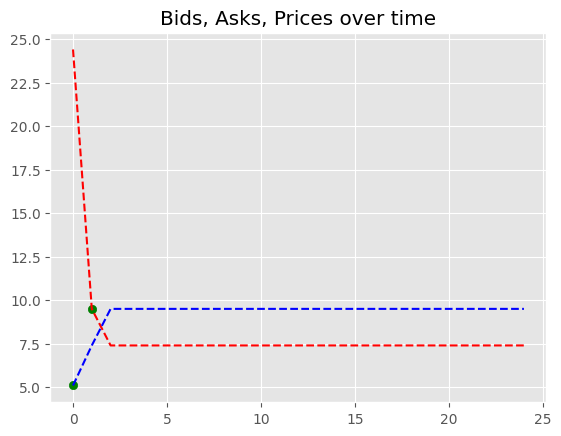

,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,price,bprofit,sprofit
0,0,[24.4],[5.1],24.4,0,5.1,0,5.1,19.3,0.0
1,1,[9.5],[7.4],9.5,0,7.4,0,9.5,0.0,2.1
2,2,[7.4],[9.5],7.4,0,9.5,0,NaN,0.0,0.0
3,3,[7.4],[9.5],7.4,0,9.5,0,NaN,0.0,0.0
4,4,[7.4],[9.5],7.4,0,9.5,0,NaN,0.0,0.0
5,5,[7.4],[9.5],7.4,0,9.5,0,NaN,0.0,0.0
6,6,[7.4],[9.5],7.4,0,9.5,0,NaN,0.0,0.0
7,7,[7.4],[9.5],7.4,0,9.5,0,NaN,0.0,0.0
8,8,[7.4],[9.5],7.4,0,9.5,0,NaN,0.0,0.0
9,9,[7.4],[9.5],7.4,0,9.5,0,NaN,0.0,0.0


In [219]:
db.graph_period(rnd, period)
db.get_period(rnd, period)

0 0
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


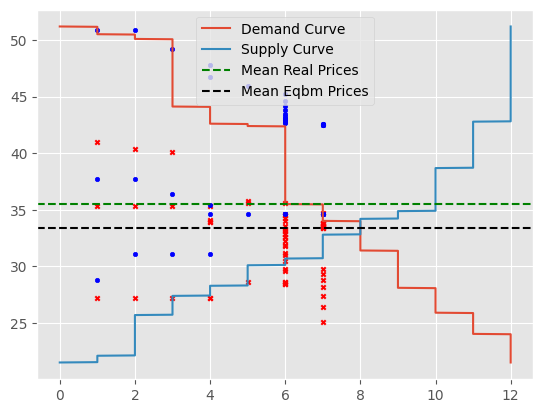

Eqbm quantity: 8
Eqbm prices: 32.82702702702703 to 33.986486486486484
Avg Prices: 35.471428571428575
Actual quantity 7


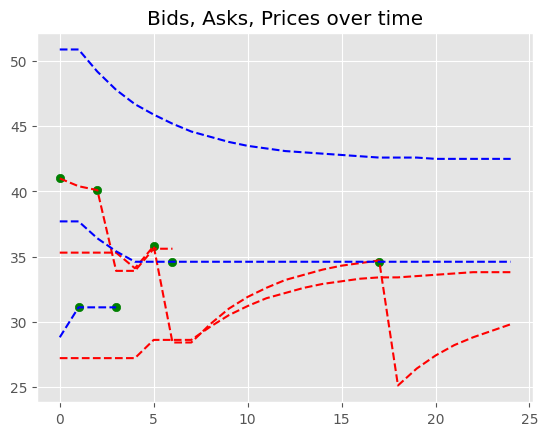

0 1
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


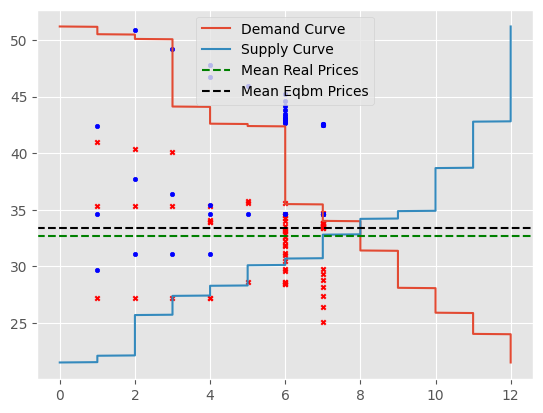

Eqbm quantity: 8
Eqbm prices: 32.82702702702703 to 33.986486486486484
Avg Prices: 32.714285714285715
Actual quantity 7


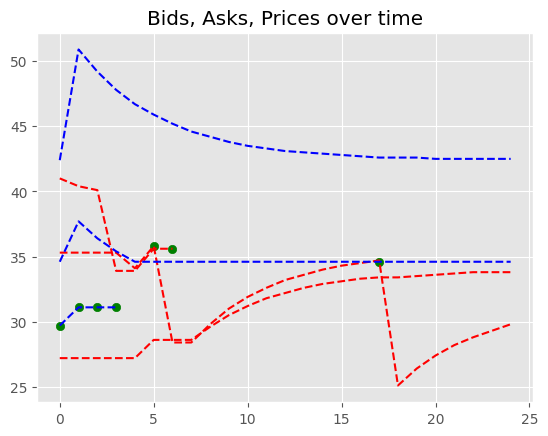

0 2
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


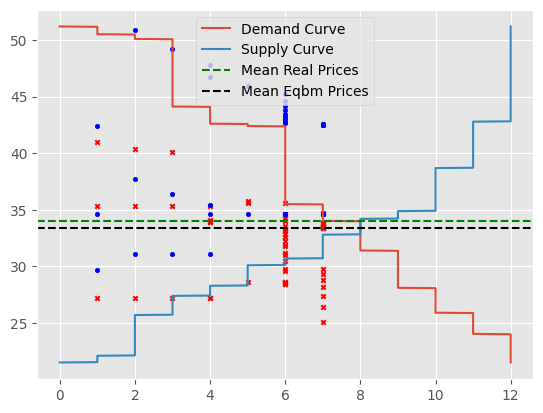

Eqbm quantity: 8
Eqbm prices: 32.82702702702703 to 33.986486486486484
Avg Prices: 34.028571428571425
Actual quantity 7


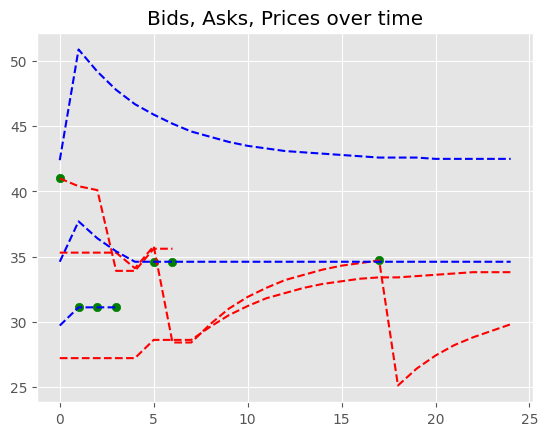

0 3
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


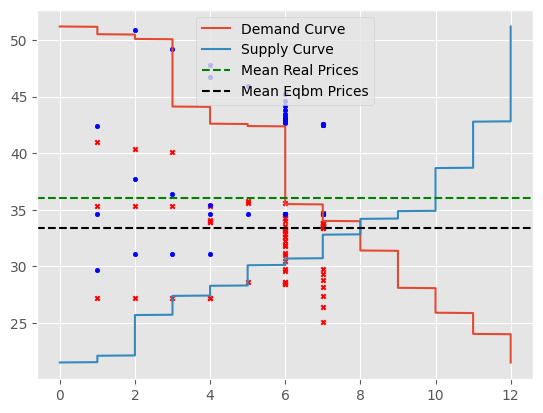

Eqbm quantity: 8
Eqbm prices: 32.82702702702703 to 33.986486486486484
Avg Prices: 36.07142857142858
Actual quantity 7


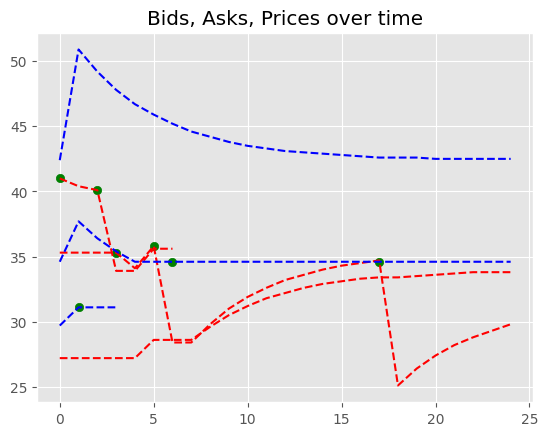

1 0
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


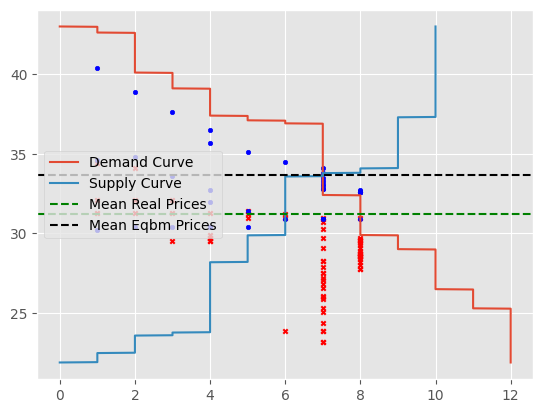

Eqbm quantity: 7
Eqbm prices: 33.6011011011011 to 33.79119119119119
Avg Prices: 31.224999999999998
Actual quantity 8


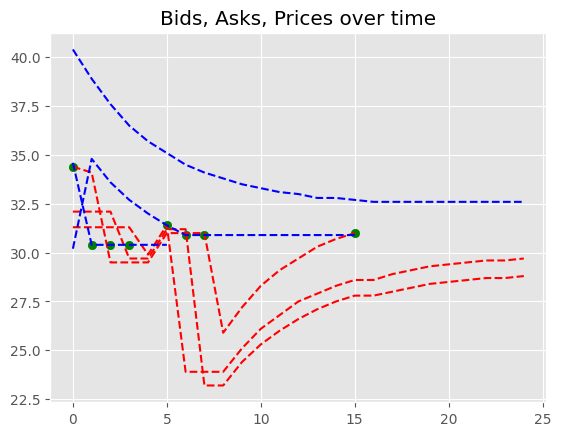

1 1
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


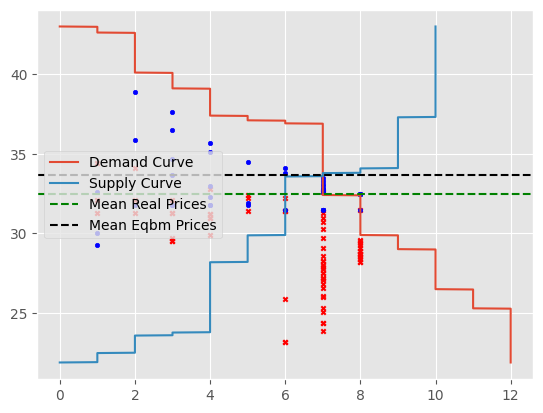

Eqbm quantity: 7
Eqbm prices: 33.6011011011011 to 33.79119119119119
Avg Prices: 32.5
Actual quantity 8


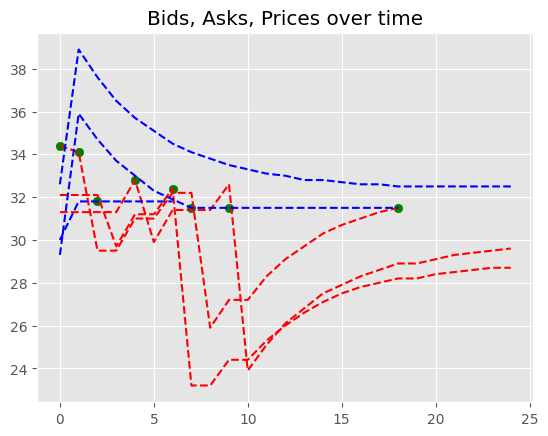

1 2
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


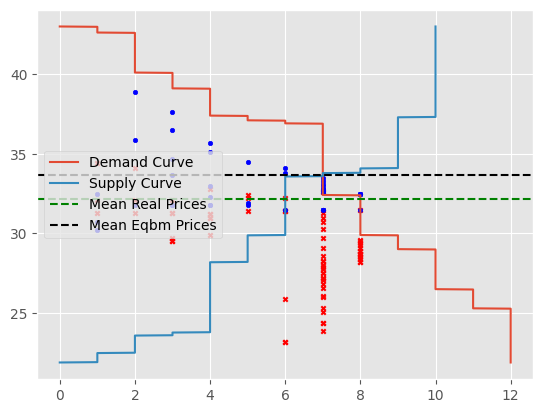

Eqbm quantity: 7
Eqbm prices: 33.6011011011011 to 33.79119119119119
Avg Prices: 32.1625
Actual quantity 8


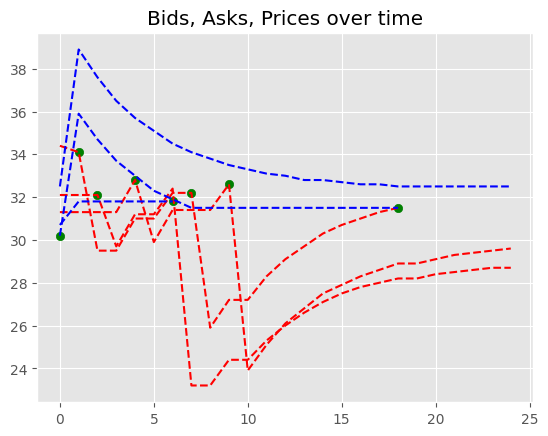

1 3
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


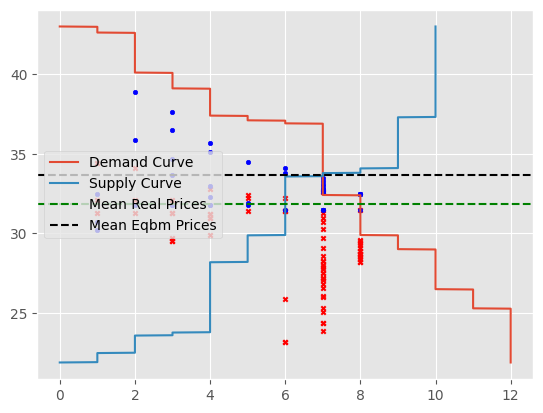

Eqbm quantity: 7
Eqbm prices: 33.6011011011011 to 33.79119119119119
Avg Prices: 31.825000000000003
Actual quantity 8


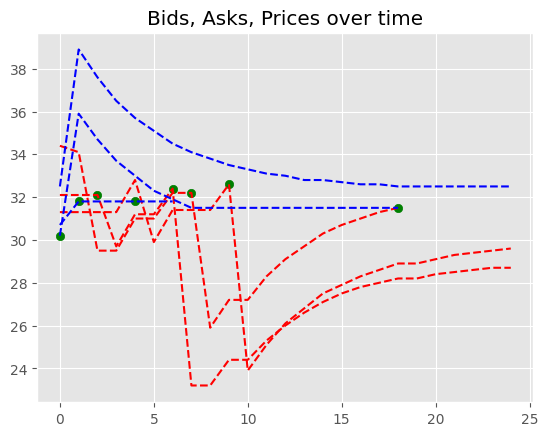

2 0
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


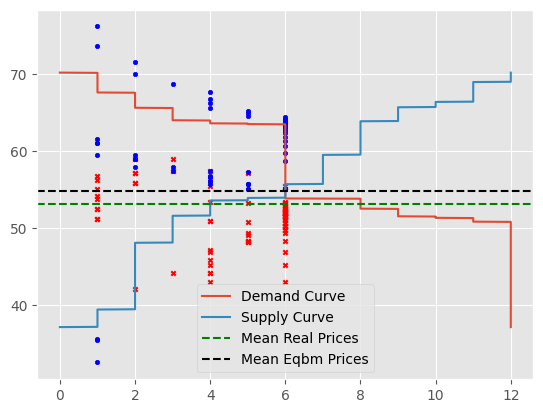

Eqbm quantity: 6
Eqbm prices: 53.93163163163163 to 55.687687687687685
Avg Prices: 53.11666666666667
Actual quantity 6


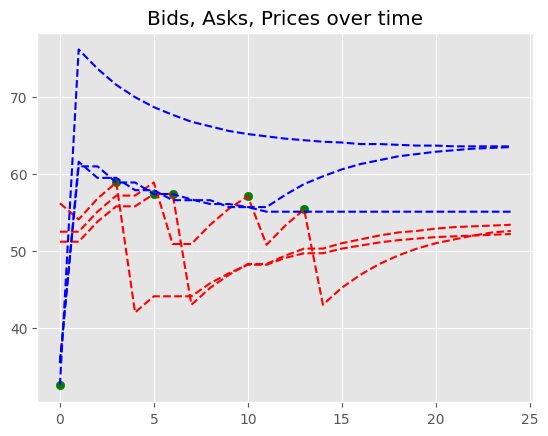

2 1
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


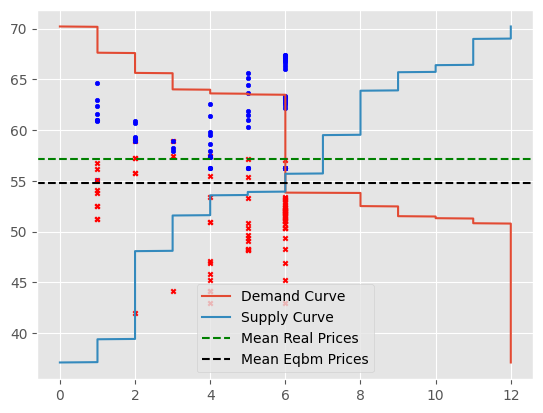

Eqbm quantity: 6
Eqbm prices: 53.93163163163163 to 55.687687687687685
Avg Prices: 57.11666666666667
Actual quantity 6


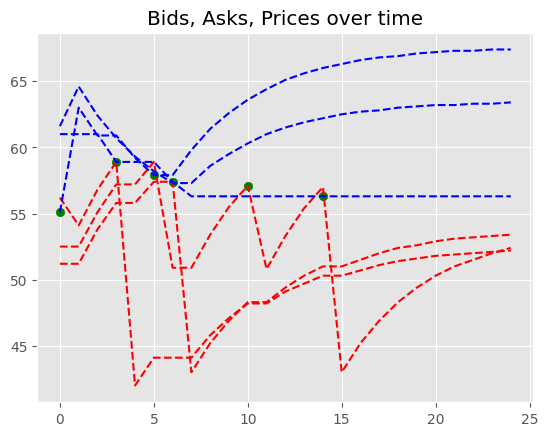

2 2
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


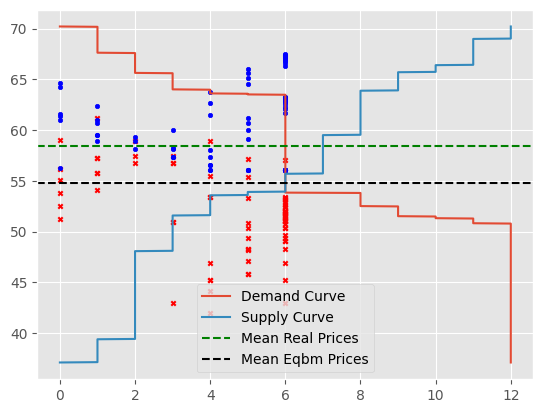

Eqbm quantity: 6
Eqbm prices: 53.93163163163163 to 55.687687687687685
Avg Prices: 58.4
Actual quantity 6


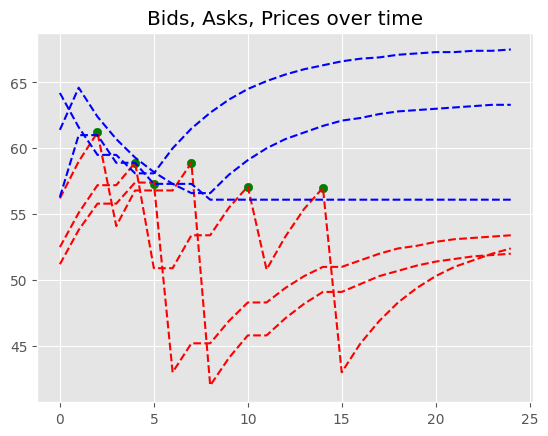

2 3
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


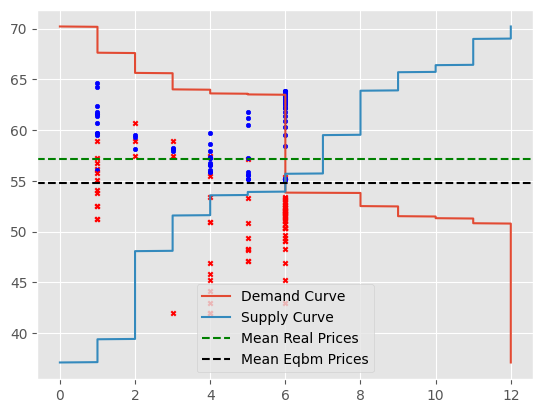

Eqbm quantity: 6
Eqbm prices: 53.93163163163163 to 55.687687687687685
Avg Prices: 57.150000000000006
Actual quantity 6


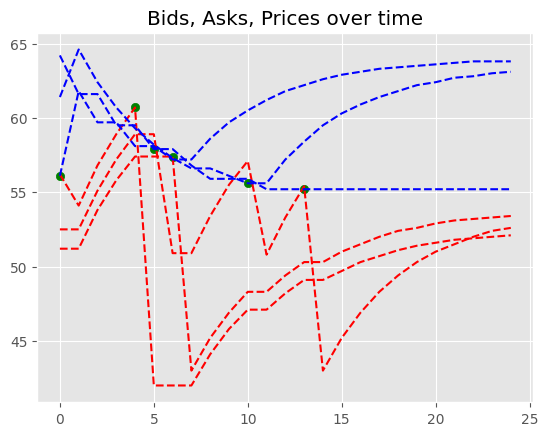

3 0
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


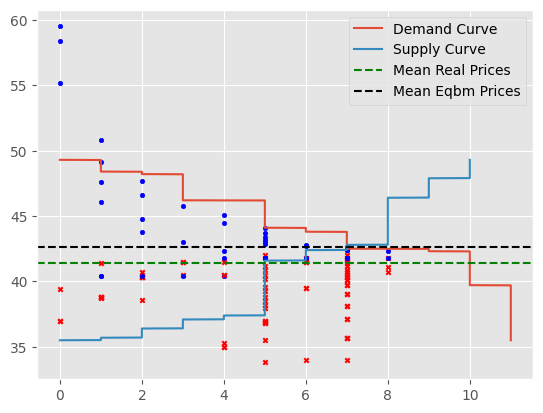

Eqbm quantity: 7
Eqbm prices: 42.5036036036036 to 42.79369369369369
Avg Prices: 41.4125
Actual quantity 8


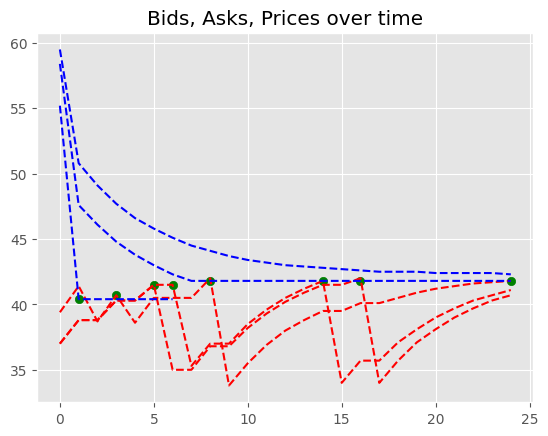

3 1
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


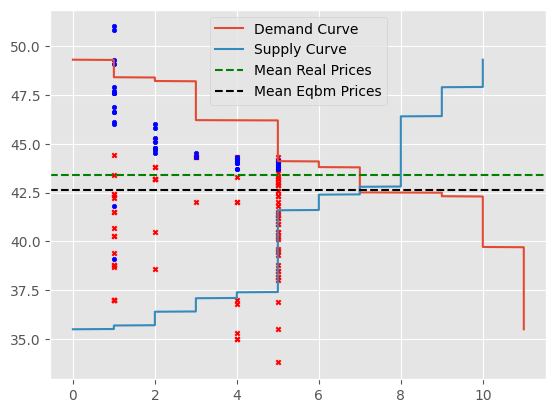

Eqbm quantity: 7
Eqbm prices: 42.5036036036036 to 42.79369369369369
Avg Prices: 43.419999999999995
Actual quantity 5


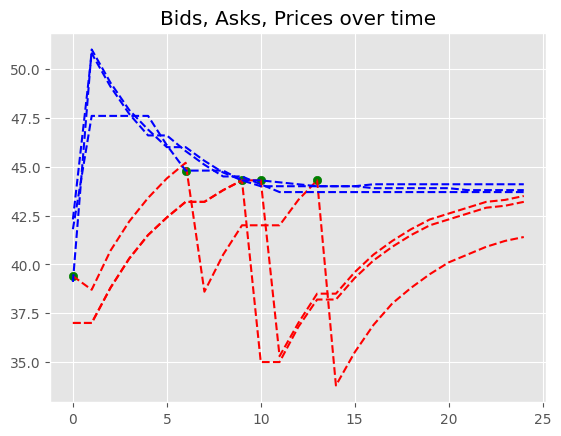

3 2
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


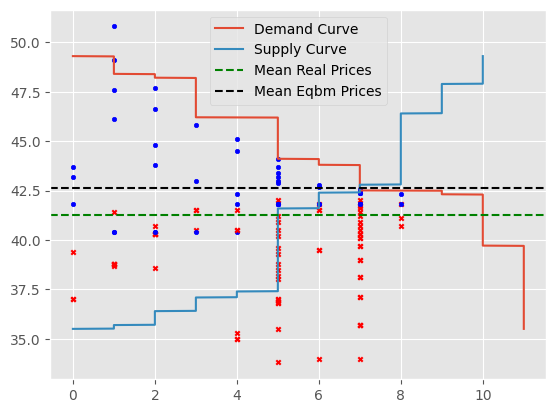

Eqbm quantity: 7
Eqbm prices: 42.5036036036036 to 42.79369369369369
Avg Prices: 41.275
Actual quantity 8


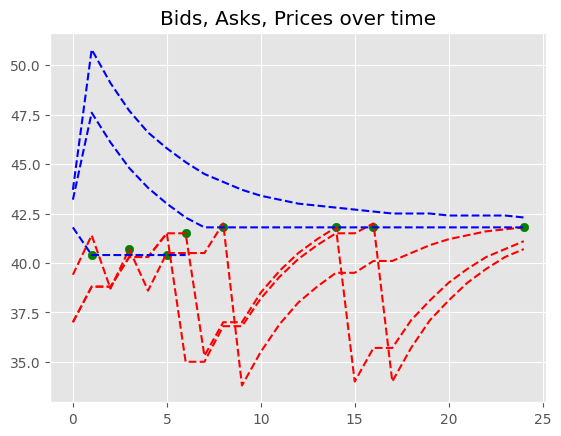

3 3
Rounds:4, Periods4, Tokens:4, Buyers:3, Sellers3, R1 to R4:(20, 20, 20, 20)


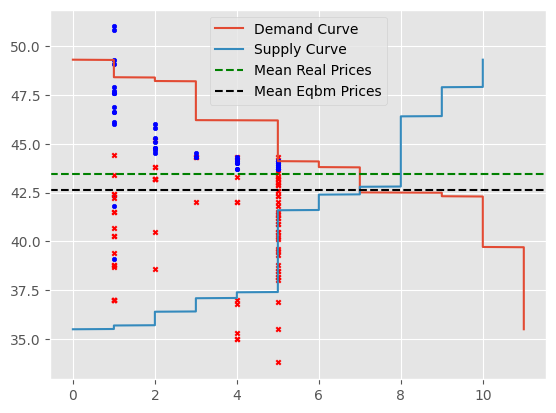

Eqbm quantity: 7
Eqbm prices: 42.5036036036036 to 42.79369369369369
Avg Prices: 43.44
Actual quantity 5


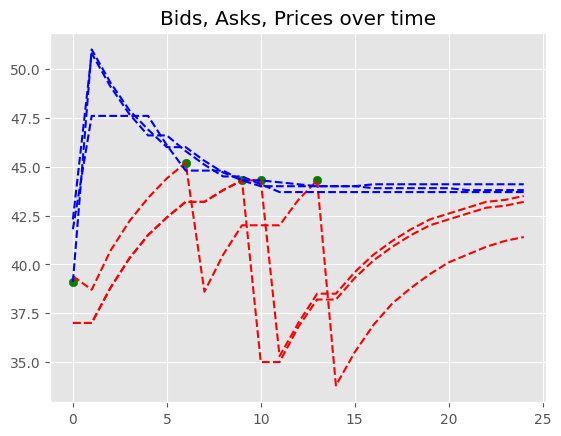

In [215]:
for rnd in range(db.nrounds):
    for period in range(db.nperiods):
        print(rnd, period)
        db.graph_period(rnd, period)

In [82]:
db.get_token_values(rnd).item()

array([[43. , 60.1, 51.3, 51.6],
       [34. , 41.2, 36.1, 35.8],
       [51.9, 54.5, 46.2, 55.4],
       [40.7, 38.2, 40.1, 49.9],
       [28.1, 38.3, 44.6, 44.8],
       [37.7, 40.9, 43.5, 37.8],
       [45.6, 43.4, 43.7, 49.9],
       [32.2, 47.2, 38.5, 42.2],
       [34.2, 30.7, 31.7, 32. ],
       [50.9, 46.4, 59.3, 57.3]])